# Baseline model
Will develop the functions needed to build a model. This will be a simple model to get started such as a decision tree or random forest. Reason for this is that we don't have to put too much effort into feature selection since we can easily regularise the depth of a decision tree (to prevent overfitting) and random forests wont overfit given the errors of the week learners are not correlated.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from data.load_sim_data import load_sim_features

pd.options.display.float_format = "{:.3f}".format

In [2]:
features = load_sim_features()

Plan
- remove useless features
- split train, validate, test (give reason for delay)
- build some metric functions. Recall, AUC, etc
- pipeline function for testing multiple models

### Split data
In reality, you would probably not know if a transaction was fraudulent on the Monday if you were predicting for the Tuesday. Given this can take time to be flagged, I will give a 1-week delay between the train and validation sets, and the test set will be the week after the validation

We do not shuffle the data before a split since it is a time series. It doesn't make sense to train a model on September data then test it on August.

In [3]:
def calculate_date_splits(start_dt, end_dt, day_delay, test_vali_size):
    train_start = datetime.datetime.strptime(start_dt, "%Y-%m-%d")
    test_end = datetime.datetime.strptime(end_dt, "%Y-%m-%d")
    test_start = test_end - datetime.timedelta(days=test_vali_size-1)
    vali_end = test_start - datetime.timedelta(days=1)
    vali_start = vali_end - datetime.timedelta(days=test_vali_size-1)
    train_end = vali_start - datetime.timedelta(days=day_delay)

    if not train_start < train_end < vali_start < vali_end < test_start < test_end:
        print(train_start.date())
        print(train_end.date())
        print(vali_start.date())
        print(vali_end.date())
        print(test_start.date())
        print(test_end.date())
        raise ValueError('Arguments done make sense since there is overlap between the dataset')

    return train_start, train_end, vali_start, vali_end, test_start, test_end

In [4]:
def split_train_vali_test(features, start_dt, end_dt, day_delay = 7, test_vali_size = 7):
    train_start,\
    train_end,\
    vali_start,\
    vali_end,\
    test_start,\
    test_end = calculate_date_splits(start_dt, end_dt, day_delay, test_vali_size)

    train = features[features['TX_DATE'].between(train_start, train_end, inclusive='both')]
    vali = features[features['TX_DATE'].between(vali_start, vali_end, inclusive='both')]
    test = features[features['TX_DATE'].between(test_start, test_end, inclusive='both')]

    return train, vali, test

In [5]:
# Set date range
start_dt = '2018-08-01'
end_dt = '2018-09-30'
day_delay = 7
test_vali_size = 7

In [6]:
# Plot splits
def get_count_stats(features):
    txn_count = features[['TX_DATE', 'TRANSACTION_ID']].groupby('TX_DATE').count()
    txn_fraud_count = features[features['TX_FRAUD'] == 1][['TX_DATE', 'TRANSACTION_ID']].groupby('TX_DATE').count()
    card_fraud_count = features[features['TX_FRAUD'] == 1][['TX_DATE', 'CUSTOMER_ID']].groupby('TX_DATE').nunique('CUSTOMER_ID')

    txn_count.columns = ['TXN_COUNT']
    txn_fraud_count.columns = ['TXN_FRAUD_COUNT']
    card_fraud_count.columns = ['COMPROMISED_CARDS']

    count_stats = pd.concat([txn_count, txn_fraud_count, card_fraud_count], axis=1)
    return count_stats

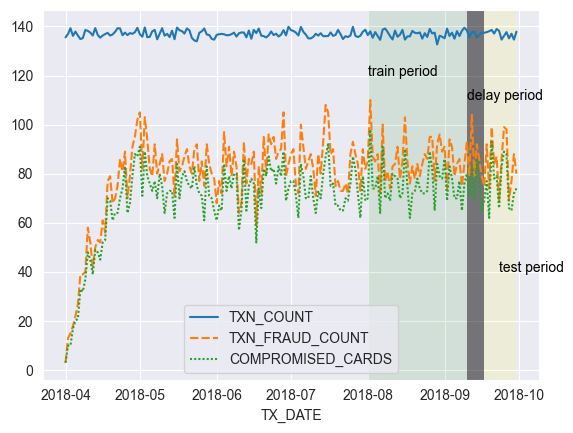

In [7]:
# Plot ts
def plot_ts_stats(features, start_dt, end_dt, day_delay, test_vali_size):
    count_stats = get_count_stats(features)
    count_stats['TXN_COUNT'] /=70 # adjust to fit on plot (easier than tuning a second axis since we just want a rough idea)

    train_start,\
    train_end,\
    vali_start,\
    vali_end,\
    test_start,\
    test_end = calculate_date_splits(start_dt, end_dt, day_delay = 7, test_vali_size = 7)

    plt1 = sns.lineplot(data=count_stats)
    plt1.axvspan(train_start, train_end, color='green', alpha=0.1, lw=0)
    plt1.text(train_start, 120, 'train period', color='black')
    plt1.axvspan(train_end, vali_start, color='black', alpha=0.5, lw=0)
    plt1.text(train_end, 110, 'delay period', color='black')
    plt1.axvspan(vali_start, test_end, color='yellow', alpha=0.1, lw=0)
    plt1.text(vali_end, 40, 'test period', color='black')

    return plt1

plt_ts = plot_ts_stats(features, start_dt, end_dt, day_delay, test_vali_size)
plt.show()

In [8]:
# Split dataset
train, vali, test = split_train_vali_test(features, start_dt, end_dt, day_delay, test_vali_size)

In [9]:
# Check date ranges
print('Train min: ', train['TX_DATE'].min())
print('Train max: ', train['TX_DATE'].max())
print('Vali min:  ', vali['TX_DATE'].min())
print('Vali max:  ', vali['TX_DATE'].max())
print('Test min:  ', test['TX_DATE'].min())
print('Test max:  ', test['TX_DATE'].max())

Train min:  2018-08-01 00:00:00
Train max:  2018-09-10 00:00:00
Vali min:   2018-09-17 00:00:00
Vali max:   2018-09-23 00:00:00
Test min:   2018-09-24 00:00:00
Test max:   2018-09-30 00:00:00


### Remove useless features
Such as txn id, etc

In [10]:
selected_features = [
  'TX_AMOUNT'
, 'TX_FRAUD'
, 'TX_ON_WEEKEND'
, 'TX_AT_NIGHT'
, 'CUSTOMER_ID_1_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_1_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_1_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_DAYS_SINCE_LAST_TXN'
, 'TERMINAL_ID_FRAUD_RISK_1_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_RISK_7_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_RISK_30_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_1_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_7_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_30_DAY_WINDOW'
]
train = train[selected_features]
vali = vali[selected_features]
test = test[selected_features]

### Check train, vali and test are reasonably similar

In [11]:
print(train.shape)
print(vali.shape)
print(test.shape)

(392670, 20)
(67611, 20)
(66715, 20)


In [12]:
print(train['TX_FRAUD'].sum()/len(train))
print(vali['TX_FRAUD'].sum()/len(vali))
print(test['TX_FRAUD'].sum()/len(test))

0.008964270252374767
0.008578485749360312
0.008948512328561793


Looks reasonable. This dataset is very imbalanced, but we will attempt to model without addressing first

### Separate out label

In [13]:
label = 'TX_FRAUD'
remaining_features = [feature for feature in selected_features if feature != label]

In [14]:
train_label = train[label]
train.drop(label, axis=1, inplace=True)
vali_label = vali[label]
vali.drop(label, axis=1, inplace=True)
test_label = test[label]
test.drop(label, axis=1, inplace=True)

### Scale the dataset for GD algos, etc

In [15]:
features_to_avoid_scaling = ['TX_ON_WEEKEND', 'TX_AT_NIGHT']
scaled_features = [feature for feature in remaining_features if feature not in features_to_avoid_scaling]

scaler = StandardScaler()

train[scaled_features] = scaler.fit_transform(train[scaled_features])
vali[scaled_features] = scaler.fit_transform(vali[scaled_features])
test[scaled_features] = scaler.fit_transform(test[scaled_features])

No binning, OHE or anything else needs to be done right now

### First baseline model - Decision tree

In [16]:
model = DecisionTreeClassifier()

# Given RF cannot overfit we throw all features it's way
model.fit(train, train_label)
pred = model.predict(vali)

print(classification_report(vali_label, pred))

pred_proba = model.predict_proba(vali)
llos = log_loss(vali_label, pred_proba)
print("Log Loss for logistic model is {0:.3f}".format(llos))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     67031
           1       0.55      0.72      0.62       580

    accuracy                           0.99     67611
   macro avg       0.77      0.86      0.81     67611
weighted avg       0.99      0.99      0.99     67611

Log Loss for logistic model is 0.257


In [17]:
model.get_n_leaves() # many leaves, could do with some pruning

1846

Accuracy is high because it is predicting mostly 0s for this heavily 0 balanced dataset.
Recall is 72% but precision is only 56%. Still doesn't look too bad for a single decision tree with absolutely no hyperparams changed.
Will need to build some more useful metrics to check this.

#### Evaluation metrics

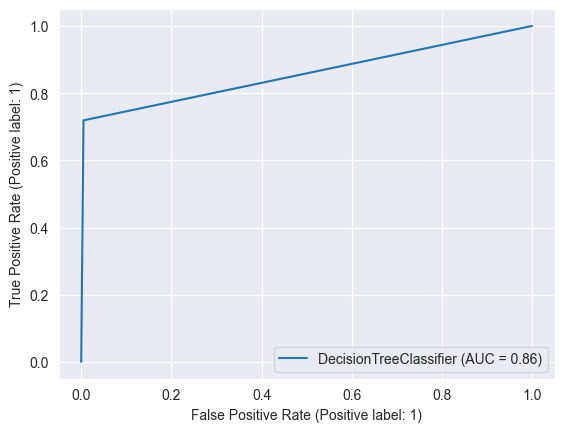

In [18]:
from sklearn.metrics import RocCurveDisplay
# RocCurveDisplay.from_predictions(vali_label, pred)
RocCurveDisplay.from_estimator(model, vali, vali_label)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(vali_label, pred)

0.8569466186257619

Classification threshold does not matter much for this model as seen in the sharp increase in the curve.
Will keep add evaluation metrics before building a better model.

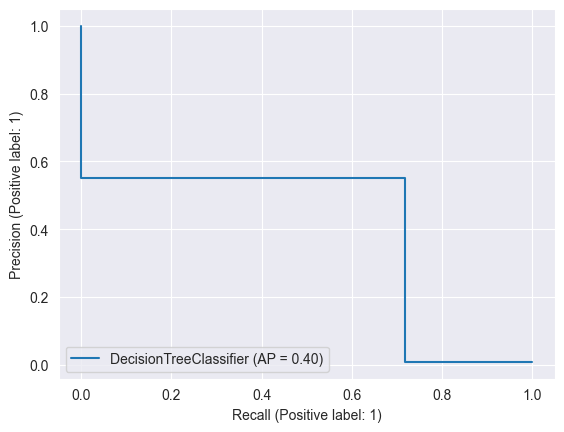

In [20]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model, vali, vali_label)
plt.show()

In [21]:
average_precision_score(vali_label, pred)

0.3984592263815864

Terrible average precision at all classification thresholds, indicates that this model is an over predictor.
Out of interest we can see the proportion of fraud predictions compared to the label

In [22]:
prep_prop = sum(pred)/len(pred)
actual_prop = sum(vali_label)/len(vali_label)
print('Pred prop: ' + str(prep_prop))
print('Actual prop: ' + str(actual_prop))

Pred prop: 0.011196402952182338
Actual prop: 0.008578485749360312


In [23]:
prep_prop/actual_prop

1.3051724137931033

37% more frauds identified in the predicted which indicates the model is too sensitive to predict a fraud example. This is further supported by the reasonably high recall and low precision of the TRUE cases.

#### Wrap up into a metrics function

In [24]:
def fraud_eval_metrics(model, labels, pred_labels, pred_proba):
    from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, average_precision_score, recall_score, f1_score, balanced_accuracy_score

    eval_metrics = {}
    pred_proba_positive = pred_proba[:,1] # takes the probabilities of the positive label

    eval_metrics['model_name'] = str(model)

    eval_metrics['log_loss'] = log_loss(labels, pred_proba_positive)
    eval_metrics['roc_auc'] = roc_auc_score(labels, pred_proba_positive)
    eval_metrics['accuracy'] = accuracy_score(labels, pred_labels)
    eval_metrics['balanced_accuracy'] = balanced_accuracy_score(labels, pred_labels)
    eval_metrics['precision'] = precision_score(labels, pred_labels)
    eval_metrics['avg_precision'] = average_precision_score(labels, pred_proba_positive)
    eval_metrics['recall'] = recall_score(labels, pred_labels)
    eval_metrics['f1'] = f1_score(labels, pred_labels)

    prep_prop = sum(pred_labels)/len(pred_labels)
    actual_prop = sum(labels)/len(labels)
    eval_metrics['proportion_comparison'] = prep_prop/actual_prop

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics, orient='index').T
    eval_metrics_df.round(3)

    return eval_metrics_df

In [25]:
dt_eval = fraud_eval_metrics(model, labels=vali_label, pred_labels=pred, pred_proba=pred_proba)
dt_eval.T

,0
model_name,DecisionTreeClassifier()
log_loss,0.257
roc_auc,0.857
accuracy,0.993
balanced_accuracy,0.857
precision,0.551
avg_precision,0.398
recall,0.719
f1,0.624
proportion_comparison,1.305


What we can see from this is that
- AUC shows prediction is much better at random for all thresholds
- accuracy is high, but this doesn't mean much with a heavily unbalanced dataset
- precision is very low, meaning when it predicts fraud is wrong 48% of the time
- average precision shows it's even lower over all classification thresholds
- recall is ok, but still need to do a lot better for flagging fraud
- F1 score is the harmonic mean of precision and recall
- Proportion of fraud predictions is higher than actual fraud flags

In summary, the baseline model is better than random, although predicting too many fraud cases and getting it wrong a lot of the time because of this and general accuracy. Also, it's missing almost 30% of fraud cases, which needs to be improved.

In [26]:
def gen_eval_plots(model, labels, pred_labels, pred_proba):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.metrics import roc_curve, RocCurveDisplay, auc
    from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

    eval_plots = {}
    pred_proba_positive = pred_proba[:,1] # takes the probabilities of the positive label
    estimator_name = str(model)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(labels, pred_proba_positive)
    roc_auc = auc(fpr, tpr)
    eval_plots['roc'] = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator_name)

    # Plot precision recall curve
    precision, recall, thresholds = precision_recall_curve(labels, pred_proba_positive)
    avg_prec = average_precision_score(labels, pred_proba_positive)
    eval_plots['prc'] = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_prec, estimator_name=estimator_name)

    # Plot confusion matrix
    conf_mat = confusion_matrix(labels, pred_labels)
    eval_plots['confusion'] = ConfusionMatrixDisplay(conf_mat)

    return eval_plots

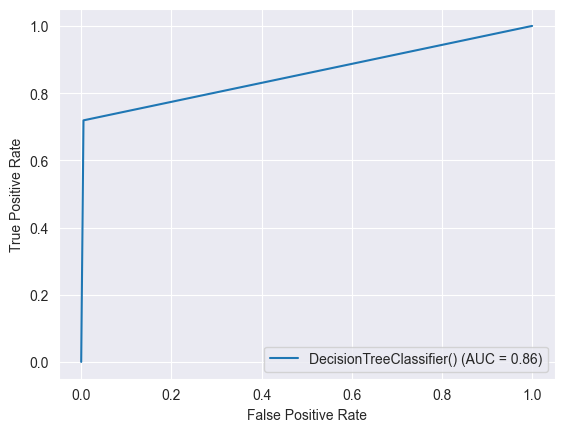

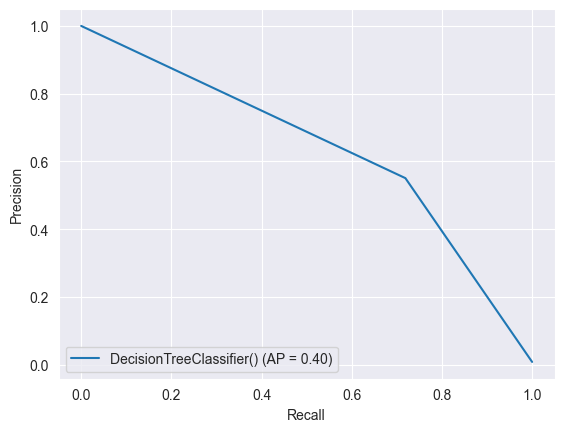

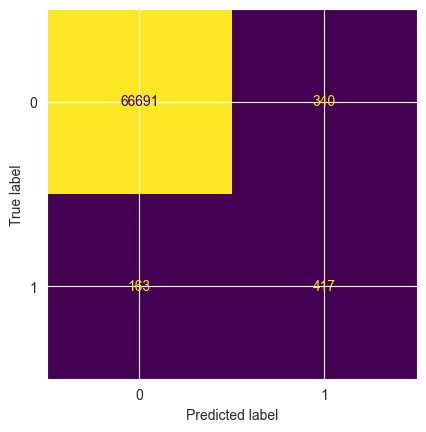

In [27]:
eval_plots = gen_eval_plots(model, labels=vali_label, pred_labels=pred, pred_proba=pred_proba)
eval_plots['roc'].plot()
eval_plots['prc'].plot(drawstyle="default")
eval_plots['confusion'].plot(colorbar=False)

### Try multiple different types of models
Trying without much tuning

In [28]:
def train_and_score_models(models, train, train_label, test, test_label):
    dt_eval = pd.DataFrame()
    eval_plots = {}
    for model in models:
        try:
            print('Training: ' + str(model))
            start_time=time.time()
            model.fit(train, train_label)
            train_time=time.time()-start_time

            print('Scoring: ' + str(model))
            start_time=time.time()
            pred_labels = model.predict(test)
            pred_proba = model.predict_proba(test)
            score_time=time.time()-start_time

            print('Evaluating: ' + str(model))
            dt_eval_instance = fraud_eval_metrics(model, labels=test_label, pred_labels=pred_labels, pred_proba=pred_proba)
            dt_eval_instance['train_time'], dt_eval_instance['score_time'] = [train_time, score_time] # add execution time
            dt_eval = pd.concat([dt_eval, dt_eval_instance])

            eval_plots[str(model)] = gen_eval_plots(model, labels=test_label, pred_labels=pred_labels, pred_proba=pred_proba)
        except:
            print('Failed to train: ', str(model))
    return dt_eval, eval_plots

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

random_state = 11

models = (
    DecisionTreeClassifier(max_depth=3, random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(n_estimators=100, max_depth=10, max_features=10, random_state=random_state),
    GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_leaf=3, max_features=10, random_state=random_state),
    LogisticRegression(penalty='l1', solver='liblinear', random_state=random_state)
)

In [30]:
eval_all, eval_plots = train_and_score_models(models = models, train=train, train_label=train_label, test=vali, test_label=vali_label)

Training: DecisionTreeClassifier(max_depth=3, random_state=11)
Scoring: DecisionTreeClassifier(max_depth=3, random_state=11)
Evaluating: DecisionTreeClassifier(max_depth=3, random_state=11)
Training: DecisionTreeClassifier(random_state=11)
Scoring: DecisionTreeClassifier(random_state=11)
Evaluating: DecisionTreeClassifier(random_state=11)
Training: RandomForestClassifier(max_depth=10, max_features=10, random_state=11)
Scoring: RandomForestClassifier(max_depth=10, max_features=10, random_state=11)
Evaluating: RandomForestClassifier(max_depth=10, max_features=10, random_state=11)
Training: GradientBoostingClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                           random_state=11)
Scoring: GradientBoostingClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                           random_state=11)
Evaluating: GradientBoostingClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                           random_state=11)
Training: Logistic

In [31]:
eval_all

,model_name,log_loss,roc_auc,accuracy,balanced_accuracy,precision,avg_precision,recall,f1,proportion_comparison,train_time,score_time
0,"DecisionTreeClassifier(max_depth=3, random_sta...",0.031,0.793,0.996,0.793,0.958,0.565,0.586,0.727,0.612,1.268,0.023
0,DecisionTreeClassifier(random_state=11),0.273,0.858,0.992,0.858,0.529,0.385,0.722,0.611,1.366,14.856,0.051
0,"RandomForestClassifier(max_depth=10, max_featu...",0.025,0.871,0.997,0.821,0.959,0.695,0.643,0.770,0.671,176.798,0.778
0,"GradientBoostingClassifier(max_depth=10, max_f...",0.306,0.863,0.983,0.840,0.299,0.179,0.695,0.418,2.328,225.782,0.449
0,"LogisticRegression(penalty='l1', random_state=...",0.020,0.886,0.996,0.803,0.972,0.730,0.605,0.746,0.622,16.543,0.032


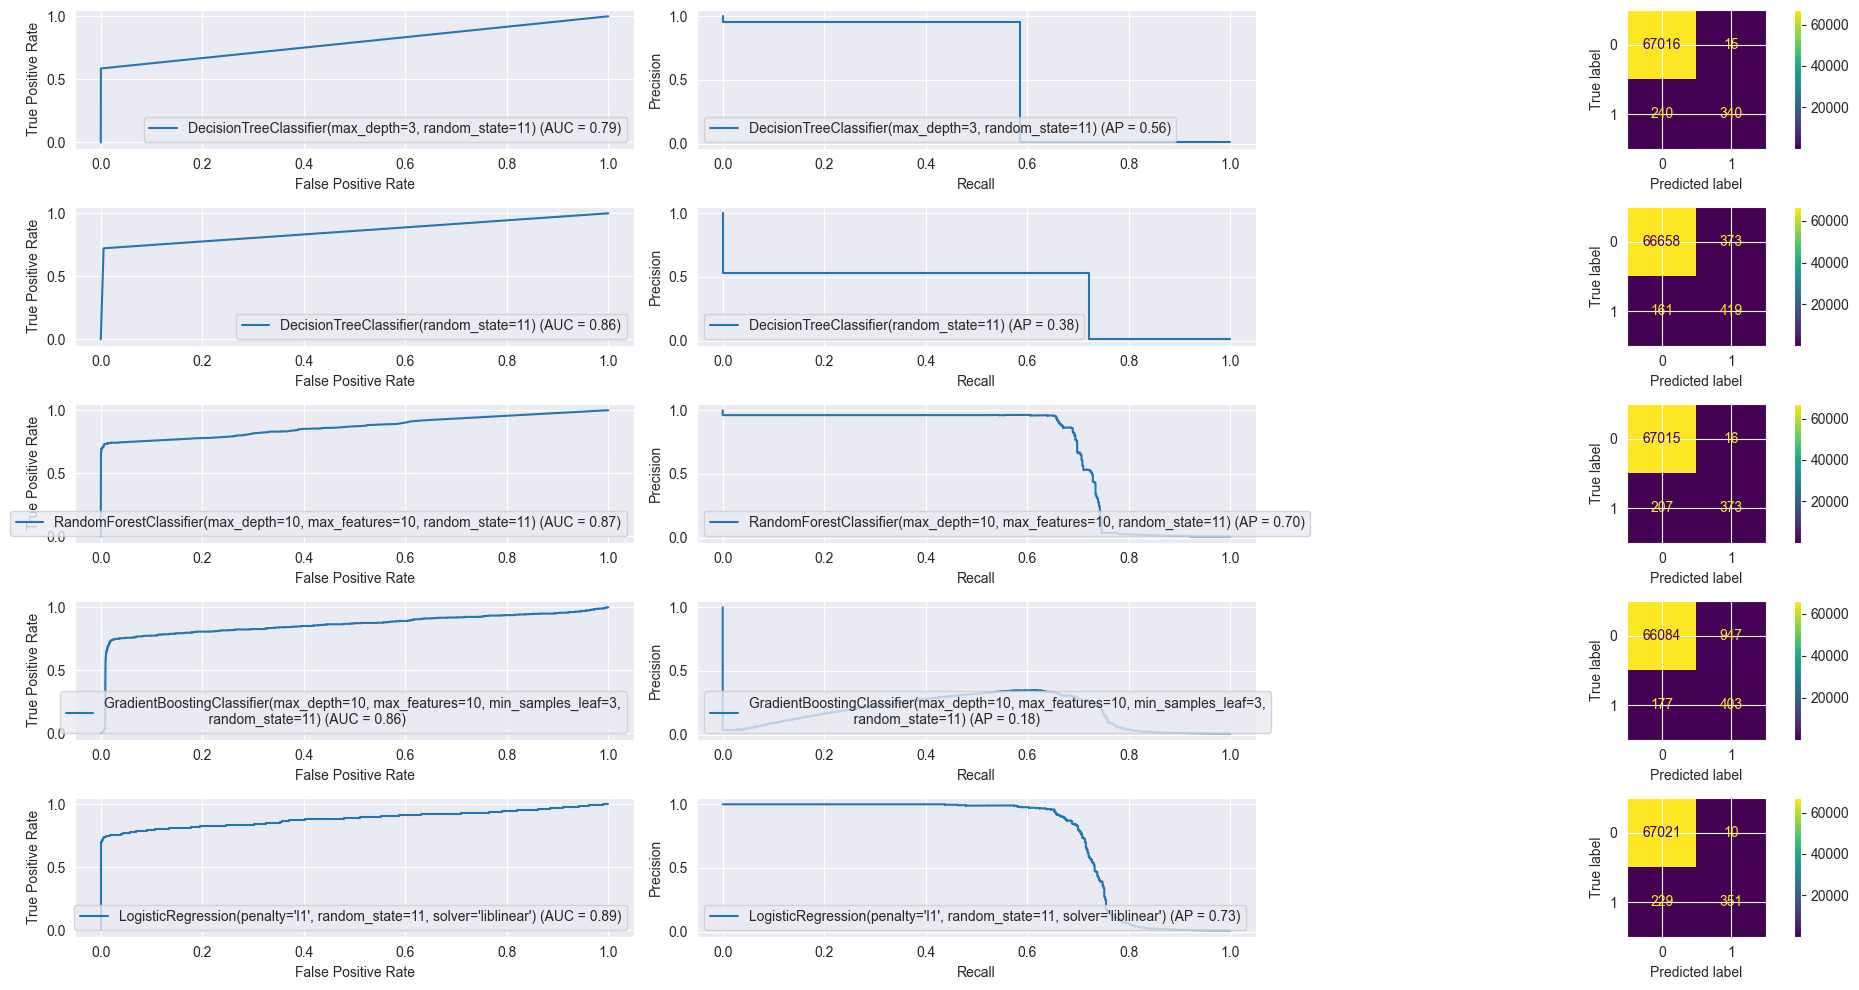

In [32]:
# Print plots
fig, axes = plt.subplots(len(models),3, figsize=(20,10)) # 3 plots per model

for plot_set, row in zip(eval_plots, range(len(eval_plots))):
    for plot_sel, col in zip(eval_plots[plot_set], range(len(eval_plots[plot_set]))):
        eval_plots[plot_set][plot_sel].plot(ax=axes[row, col])
plt.tight_layout()

### Learnings, comments and thoughts
- Model performances are quite bad, but this is expected without any tuning. The hyperparameters were based on "gut feel" so a lot more work could be done in this space.
- In the training, validation, test split we never actually used the tested data in the baseline. This is expected, since we will not use it unless we are doing a lot of hyperparameter tuning. This helps us avoid tuning to the testing data, so this function will still be useful and not have any redundancy in it's future use.
- Used a small subset of data, but could have gone smaller. Training tool a while for some of these models.
- Accuracy is almost not even worth putting in the evaluation metrics for a problem like this. The dataset is so unbalanced that accuracy always comes back very high despite it being a poor model.
- Digging deeper into feature importance, feature selection and model selection will be done in the post-baseline model building stage
- Would be good to understand the cost of missing fraud vs the cost of misclassifying normal behaviour as fraud. At first it seems like we should have a very high recall to capture all fraud instances. But high recall with low precision would lower the trust of the customer, which could have them switch banks. This should be attempted to be quantified so we can balance it with the actual financial hit that is taken when a bank has to pay a customer back due to fraudulent spending. Knowning more about this would make it easier to know where the goal posts are when building this model. For the moment, I will assume higher recall is slightly more important this precision.
- No effort has been made to handle the unbalanced dataset, but this looks like it should be done given the baseline model performance.
- Train and score time for the decision forests was high, so it may not be appropriate for a near-real-time system.
- Logistic regression seemed to do the best by a small margin, based on F1 score and AUC. Also, the log loss was low.